## Семинар 10: "Генерация текстов"

ФИО: Перфильева Нелли Андреевна

In [ ]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
from itertools import product

%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [ ]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-11-22 13:51:10--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt.3’

author-quote.txt.3  100%[===================>]   5.35M  --.-KB/s    in 0.1s    

2021-11-22 13:51:10 (55.6 MB/s) - ‘author-quote.txt.3’ saved [5615127/5615127]



In [ ]:
lines = [
    x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()
]
lines = [x.lower().replace(".", "").replace(",", "").replace("!", ""). \
         replace("?", "").replace("'", " ").replace("\"", "").replace(";", "").split()  for x in lines]

In [ ]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").\
    replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split()
    for x in open('author-quote.txt').readlines()
]

In [ ]:
lines[2:3]


[['did',
  'you',
  'ever',
  'stop',
  'to',
  'think',
  'and',
  'forget',
  'to',
  'start',
  'again?']]

In [ ]:
len(lines)

39269

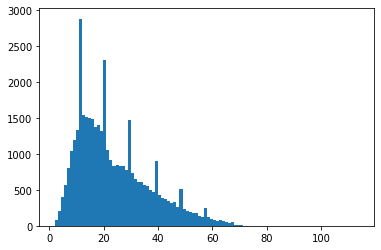

In [ ]:
plt.hist(list(map(len, lines)), bins=100);

In [ ]:
np.random.seed(777)
torch.manual_seed(777)

In [ ]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [ ]:
vocab = Vocabulary(lines)

In [ ]:
len(lines)

39269

In [ ]:
len(vocab.char_to_id)

33275

In [ ]:
#assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [ ]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [ ]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [ ]:
dataset = Quotes(lines, vocab)

In [ ]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [ ]:
vocab.size

33275

### Часть 2: определение модели

In [ ]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

### Часть 3: обучение модели

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [ ]:
losses = []

In [ ]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
oracle.cuda()

Oracle(
  (embedding): Embedding(33275, 32)
  (generator): GRU(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

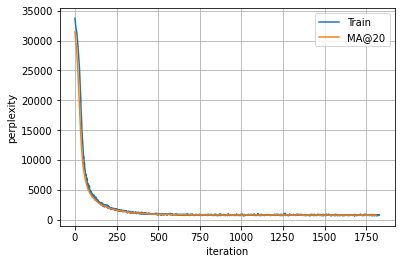

In [ ]:
for epoch in range(3):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [ ]:
oracle.cpu()
for _ in range(10):
    print(oracle.generate(vocab))

 they have from things more deterrence to mc this time to is invest scientist the accuses hope but you
 two appeals leave was romantic drive and mediocrity <eos>
 <eos>
 i where good my <eos>
 it <eos>
 press i a attention of are notes streets that office reason as makes as any and of reputation motivating
 rack jam - suspended a of have and of amongst is grateful ago if any to believe the i guys seem myself
 very human have not of <eos>
 don't rest carefully case the day dividend dead <eos>
 in <eos>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [ ]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(OracleLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [ ]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").\
    replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower() 
    for x in open('author-quote.txt').readlines()
]
vocab = Vocabulary(lines)


In [ ]:
oracle = OracleLSTM(vocab.size, embedding_size=32, hidden_size=64, layers=2)
oracle.cuda()
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
train_losses = []
test_losses = []

In [ ]:
train_size = int(len(lines) * 0.75)
test_size = len(lines) - train_size

train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

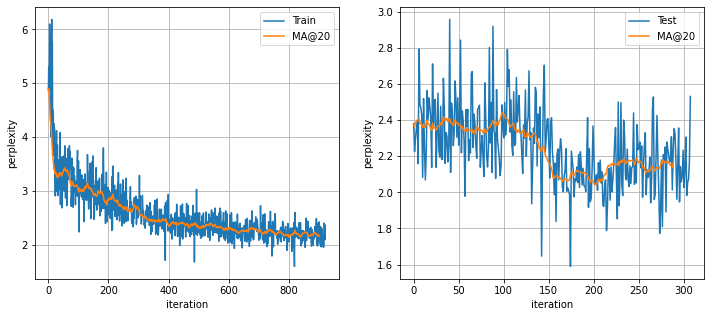

In [ ]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader))):
        oracle.zero_grad()
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (criterion(prediction, eos) * mask.float()).mean()
        train_loss.backward()    return nullptr;

        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        train_losses.append(np.exp(train_loss.item()))
    for i, batch in enumerate(tqdm(test_dataloader, total = len(test_dataloader))):
        oracle.zero_grad()
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (criterion(prediction, eos) * mask.float()).mean()
        test_losses.append(np.exp(test_loss.item()))
        
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(moving_average(train_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.plot(moving_average(test_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
oracle.cpu()
for i in range(10):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


otelf my theing for antace peiden twher being coverisitys tring indiolrs the caulabpes whof be bespo
i'n sarded whome laly gaty umantraty so the when disguol afun coded who alhs in and intent the walbi
i<eos>
hover inwate<eos>
bby the whishmrean to jind are to hexreeds worshing sanep to guavhth in thing way no i oan tirked i 
guthing sorour anss uncant 9ake thy we as fliated ut pured rythat of lives yife fon eanekitieks in w
ditgis is coasn the sto phaytheoly for pomstardtu1eynart to deked bosaas the pleaft a ond wimen't me
soset a copfite who nit hias it iritery and the uty<eos>
i plealr<eos>
a natectes i dove corparce an ipnatiound everaly sople and haple at if to suling gopell bety wammera


 #### Подбор гиперпараметров



In [ ]:
grid_losses = []
final_model = None

In [ ]:
dataloader = DataLoader(Quotes(lines, vocab), shuffle=True, batch_size=64, collate_fn=compose_batch)


In [ ]:
params = product([32, 64, 128], [32, 64, 128], )

0it [00:00, ?it/s]

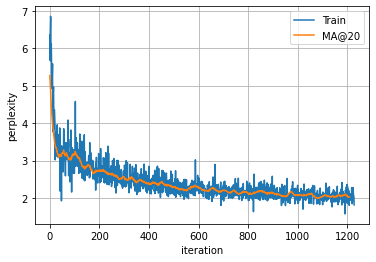

In [ ]:
for embedding_size, hidden_size in tqdm(list(params)):
    print(params)
    oracle = OracleLSTM(vocab.size, embedding_size=embedding_size,
                             hidden_size=hidden_size, layers=2)
    oracle.cuda()
    optimizer = torch.optim.Adam(oracle.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(reduction='none')
    losses = []
    for epoch in range(2):
        bar = progressbar.ProgressBar()
        for i, batch in enumerate(tqdm(dataloader, total = len(dataloader))):
            oracle.zero_grad()
            go, eos, mask, length = batch
            go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
            optimizer.step()
            losses.append(np.exp(loss.item()))
    if loss < min_loss:
        min_loss = loss
        grid_losses = losses
        final_model = oracle
plt.plot(grid_losses, label='Train')
plt.plot(moving_average(grid_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [ ]:
final_model, min_loss


(OracleLSTM(
   (embedding): Embedding(67, 64)
   (generator): LSTM(64, 64, num_layers=2)
   (classifier): Linear(in_features=64, out_features=67, bias=True)
 ), tensor(0.5966, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
oracle.cpu()
for i in range(10):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


the cloact a art dyster because edound just don't heart the will seartize give out more somening nos
them we be old that when i was to but is being other told the mint but life that zalling stufeds of 
colucking loakes kind underscares and himb to the among£s perms<eos>
i'm fould that that will be poligions with in love and the scambosc for palisary and always not fift
if i rememps undowlence when you computely?' of of along<eos>
in the shisbigs awally<eos>
the hassey<eos>
me road for a lmand who can't so only if foolled to the tood of age scholicy ivually time by cannot 
i was because forgy you have compettelly momonally the sovernyacm at that i don't ormogh<eos>
the stu midmati haman the person and ros and its and the used ever a nawn't depulce's bast' that his


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: